### **Importing Libraries**

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import keras

import cv2
import tensorflow as tf
from tensorflow.keras import models, layers

### **Getting the images directory**

* shuffle - The images will shuffle randomly
* seed - Sets the random sequence
* img_size - Sets the height and width of a image size
* batch_size - Groups the images in batch 
* example: **Consider that there are 20 images and we create 2 bacthes, then the images will be grouped by 10, 10,
i.e 1st batch will have 10 images and 2nd batch will have 10 images. If you say 4 bacths then the total number of images will be divided into 4**

In [11]:
img_size = 256
batch_size = 32

In [12]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Deep Learning/Potato Disease Classification/Potato Disease Classification",
                                                             shuffle= True,
                                                             seed = 42,
                                                             image_size=(img_size,img_size),
                                                             batch_size= batch_size)

Found 2152 files belonging to 3 classes.


#####  **Getting the class names, hence folder names from the directory**

In [13]:
class_name = dataset.class_names
class_name

['Early_Blight', 'Healthy', 'Late_Blight']

##### **Visualizing the image**

* The image is in a tensor format, So to visualize the image we have to convert the tensors into numpy.
* The numpy values are in float, So to visualize we have to change the datatype to int.

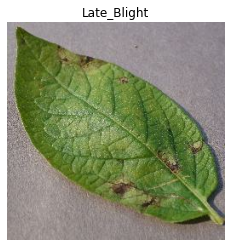

In [14]:
for img_batch, label_batch in dataset.take(1):
    plt.imshow(img_batch[1].numpy().astype("uint8"))
    plt.title(class_name[label_batch[1]])
    plt.axis("Off")


### **Creating a train test split function**


* Using 80% of data for training
* Using 10% of data for test
* Using another 10% of data of validation

In [15]:
print("Number of batches in a Dataset:", len(dataset))

# Taking 80% of data for training purpose
train_ds = dataset.take(round(len(dataset)* 0.8))

# Skipping 80% of training data and Taking remaining 20% of data for Validation and Test
val_n_test = dataset.skip(round(len(dataset)*0.8))

# Taking 10% of data from val_n_test for validation and another 10% for test data
val_ds = val_n_test.take(round(len(val_n_test)*0.5))
test_ds = val_n_test.skip(round(len(val_n_test)*0.5))

print("Train Dataset:",len(train_ds))
print()
print("Number of batches selected for test and validation:", len(val_n_test))
print("Validation Dataset:",len(val_ds))
print("Test Dataset:", len(test_ds))

Number of batches in a Dataset: 68
Train Dataset: 54

Number of batches selected for test and validation: 14
Validation Dataset: 7
Test Dataset: 7


### **Cache, Shuffle and Prefetch**


* cache() - Instead of open, read, map for each epoch, The cache will help us to store these steps for single epoch and help us in saving training purpose.

* shuffle - Shuffle, help us to shuffle the dataset.

* Prefetch - Prefetch, help us to read and train the batchs in simultaneously

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds  = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

### **Model Architecture**

##### **Resizing and Rescaling**

* Resizing helps us to size all the images to same size.
* Rescaling helps us to normalize the images between 0 to 1.

* example: Let us take the image which as values between 0 to 256, i.e 
    * 0 = Black
    * 256 = White
    * To Normalize the color values we need to multiply each values with 255, So that the values will become between 0 to 1.
    
##### **Data Augmentation**

* Data Augmentation helps us to create new random images by Rotating and Flipping the Images.

##### **CNN (Convolutional Neural Network)**

* The CNN layer helps us to create 32 filters with 3,3 kernal with relu activation function for 32 batches of image size 256, 256 with color 3 RGB.


##### **Flatten**

* Flattend Layer helps us to flatten all the data values in a Vertical Side to fit into a neural network.

##### **Dense Layer**

* The 1st Layer is an Input Layer, Which has 64 neurons. i.e 64 Input Values with a ReLU activation Funtion.
* The 2nd and 3rd Layers are hidden Layers, which is followed by 64, 32 nerouns in each layer with ReLU Function.
* The 4th Layer is an Output Layer with 3 Neurons, Which as Softmax Function.



In [17]:
model = models.Sequential([
    
    # Resizing and Rescaling
    layers.experimental.preprocessing.Resizing(256, 256),
    layers.experimental.preprocessing.Rescaling(1./255),
    
    # Data Augmentation
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
    #CNN Layer 1(Convolutional Neural Network)
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    
    # CNN Layer 2
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    
    # CNN Layer 3
    layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    
    # Flatten Layer
    layers.Flatten(),
    
    # Dense Layer
    layers.Dense(64, activation="relu"),
    
    # Hidden Layer 1
    layers.Dense(32, activation="relu"),
    
    # Hidden Layer 2
    layers.Dense(32, activation="relu"),
    
    # Output Layer
    layers.Dense(3, activation="softmax")                                              
])

model.build(input_shape=(32,256,256,3))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (32, 256, 256, 3)         0         
                                                                 
 rescaling (Rescaling)       (32, 256, 256, 3)         0         
                                                                 
 random_flip (RandomFlip)    (32, 256, 256, 3)         0         
                                                                 
 random_rotation (RandomRota  (32, 256, 256, 3)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                      

### **Compiling the Model**

* Compiling the dataset with adam optimizer and using SparseCategoricalCrossentropy.

In [19]:
model.compile(optimizer = "adam",
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"]
             )

### **Training the model**

* Training the model with 20 epochs.

In [20]:
history = model.fit(train_ds,
          batch_size = 32,
          validation_data = val_ds,
          verbose=1,
          epochs=20,
)

Epoch 1/20
54/54 [==============================] - 405s 830ms/step - loss: 0.6441 - accuracy: 0.6892 - val_loss: 0.4227 - val_accuracy: 0.8482
Epoch 2/20
54/54 [==============================] - 5s 95ms/step - loss: 0.3148 - accuracy: 0.8791 - val_loss: 0.2616 - val_accuracy: 0.9152
Epoch 3/20
54/54 [==============================] - 5s 94ms/step - loss: 0.2593 - accuracy: 0.8964 - val_loss: 0.2566 - val_accuracy: 0.9152
Epoch 4/20
54/54 [==============================] - 5s 94ms/step - loss: 0.2220 - accuracy: 0.9201 - val_loss: 0.1713 - val_accuracy: 0.9330
Epoch 5/20
54/54 [==============================] - 5s 94ms/step - loss: 0.2627 - accuracy: 0.9022 - val_loss: 0.1593 - val_accuracy: 0.9598
Epoch 6/20
54/54 [==============================] - 5s 93ms/step - loss: 0.1825 - accuracy: 0.9271 - val_loss: 0.1680 - val_accuracy: 0.9286
Epoch 7/20
54/54 [==============================] - 5s 94ms/step - loss: 0.1425 - accuracy: 0.9439 - val_loss: 0.0948 - val_accuracy: 0.9777
Epoch 8/20

### **Evaluating the model** 

* The model shows an Accuracy of 0.9900, Which is absolutely great.

In [21]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 5s 64ms/step - loss: 0.0850 - accuracy: 0.9750


In [22]:
scores

[0.08499451726675034, 0.9750000238418579]

In [23]:
history.params

{'epochs': 20, 'steps': 54, 'verbose': 1}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### **Plotting Loss & Accuracy and Validation Loss & Validation Accuracy**

In [25]:
loss = history.history["loss"]
acc = history.history["accuracy"]

val_loss = history.history["val_loss"]
val_acc = history.history["val_accuracy"]

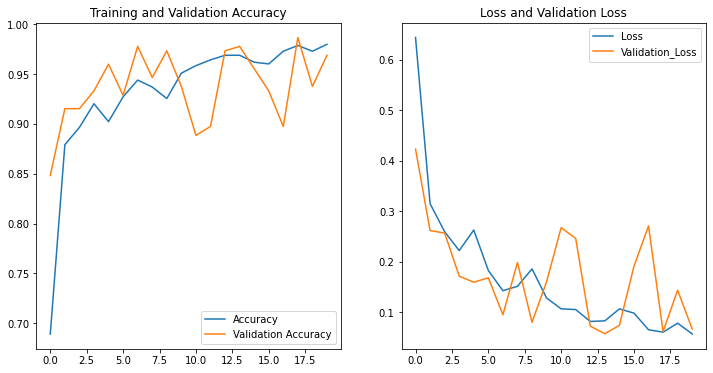

In [26]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(20), acc, label="Accuracy")
plt.plot(range(20), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")


plt.subplot(1,2,2)
plt.plot(range(20), loss, label="Loss")
plt.plot(range(20), val_loss,label="Validation_Loss")
plt.legend(loc="upper right")
plt.title("Loss and Validation Loss")
plt.show()

### **Prediction on a Sample Image**

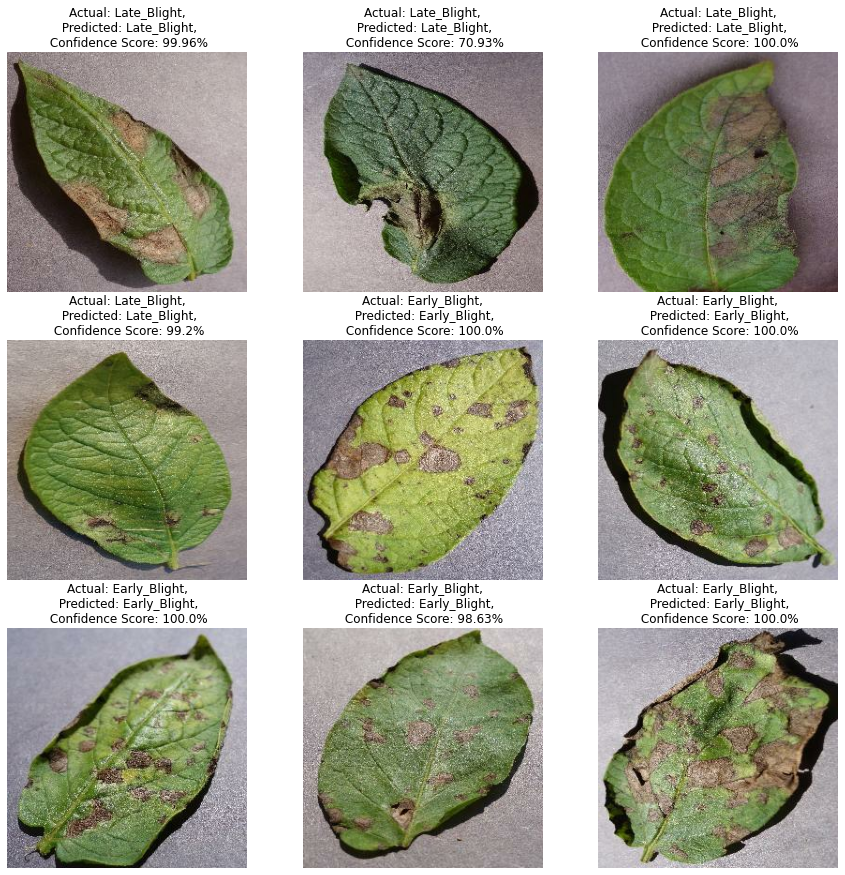

In [27]:
plt.figure(figsize=(15,15))
for img_batch, label_batch in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i + 1)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    actual_cls = class_name[label_batch[i]]

    prediction = model.predict(img_batch)
    predicted_cls = class_name[np.argmax(prediction[i])]
    confidence = round(100 * (np.max(prediction[i])), 2)

    plt.title(f"Actual: {actual_cls},\n Predicted: {predicted_cls},\n Confidence Score: {confidence}%")
    plt.axis("off")


### **Saving the Model**

In [29]:
model.save("/content/drive/MyDrive/Deep Learning/Potato Disease Classification/potatoe_disease_classifier.h5")

### **Loading the model for testing**

In [32]:
new_model = keras.models.load_model("/content/drive/MyDrive/Deep Learning/Potato Disease Classification/potatoe_disease_classifier.h5")

Late_Blight
0.95


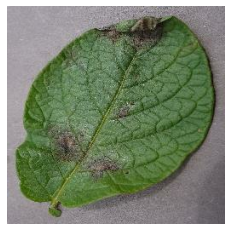

In [73]:
for img,label in test_ds.take(1):
  prediction = model.predict(img)
  print(class_name[np.argmax(prediction[0])])
  print(round(np.max(prediction[0]),2))
  plt.imshow(img[0].numpy().astype("uint8"))
  plt.axis("off")
  break